In [1]:
import pandas as pd
from plotnine import *
import glob
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

In [2]:
"twitter_small_records.json".rsplit(".", 1)[0].rsplit("_", 1)

['twitter_small', 'records']

In [3]:
results_arr = []
for tool in ["results", "pyresults"]:
    for gpu in ["a4000", "a5000", "a6000", "a100"]:
        resfiles = glob.glob(f"{tool}/{gpu}/*")
        for resfile in resfiles:
            multiplier = resfile.rsplit(".", 1)[0].rsplit("_", 1)[1]#.rsplit("x", 1)[0])
            if "x" not in multiplier:
                multiplier = "1x"
            df = pd.read_json(resfile)
            df.columns = ["duration"]
            df["size"] = multiplier
            df["gpu"] = gpu.capitalize()
            if tool == "results":
                df["tool"] = "GpJSON"
            else:
                df["tool"] = "cuDF (RAPIDS)"
                df["duration"] = df["duration"]*1000
            results_arr.append(df)

results_df = pd.concat(results_arr).reset_index(drop=True)
results_df

,duration,size,gpu,tool
0,1758.579906,8x,A4000,GpJSON
1,1758.426807,8x,A4000,GpJSON
2,1756.024880,8x,A4000,GpJSON
3,1755.856344,8x,A4000,GpJSON
4,1726.716371,8x,A4000,GpJSON
...,...,...,...,...
475,2470.095678,2x,A100,cuDF (RAPIDS)
476,2526.769276,2x,A100,cuDF (RAPIDS)
477,2468.264038,2x,A100,cuDF (RAPIDS)
478,2538.253156,2x,A100,cuDF (RAPIDS)


In [4]:
a6meds = (results_df.loc[results_df["gpu"] == "A6000"]
.groupby(["tool", "size"]).median().reset_index())
a6meds

/var/folders/jp/kcn5ldrd1279m_wgrm1vvnvr0000gn/T/ipykernel_82389/607426829.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,tool,size,duration
0,GpJSON,0.125x,49.810814
1,GpJSON,0.25x,71.231813
2,GpJSON,0.5x,121.580695
3,GpJSON,1x,235.115859
4,GpJSON,2x,414.860203
5,GpJSON,4x,747.724789
6,GpJSON,8x,1480.326830
7,cuDF (RAPIDS),0.125x,404.716967
8,cuDF (RAPIDS),0.25x,568.807680
9,cuDF (RAPIDS),0.5x,912.363935


In [5]:
gpdf = a6meds.loc[a6meds["tool"] == "GpJSON"].reset_index(drop=True)
cuddf = a6meds.loc[a6meds["tool"] == "cuDF (RAPIDS)"].reset_index(drop=True)
cuddf["duration"] / gpdf["duration"]

0    8.125082
1    7.985304
2    7.504184
3    6.451536
4    6.055322
5         NaN
6         NaN
Name: duration, dtype: float64

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/datasetsize_vs_rapids.pdf


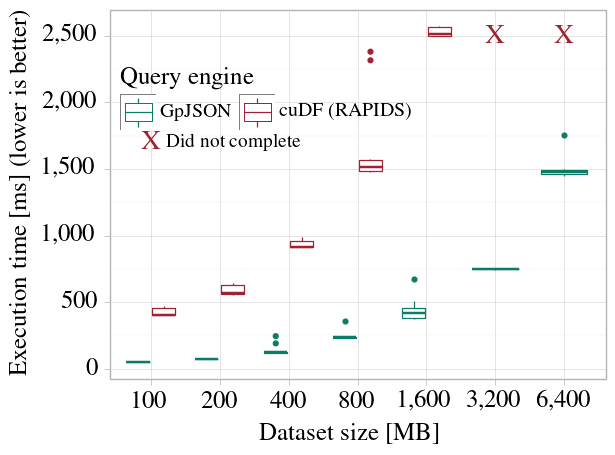

<ggplot: (350956517)>

In [6]:
plt = (
    ggplot(results_df.loc[results_df["gpu"] == "A6000"].reset_index(drop=True))
    + geom_boxplot(aes(x="size", y="duration", color="tool"))
    + annotate("text", x=6, y=2500, label="X", color="#A02334", size=20)
    + annotate("text", x=7, y=2500, label="X", color="#A02334", size=20)
    + annotate("text", x=1, y=1700, label="X", color="#A02334", size=20)
    + annotate("text", x=2.2, y=1700, label="Did not complete", size=14)
    + scale_y_continuous(breaks=[0,500,1000,1500,2000,2500],
                        labels=["0", "500", "1,000", "1,500", "2,000", "2,500"])
    + scale_x_discrete(labels=["100","200","400","800","1,600","3,200","6,400"])
    + scale_color_manual(["#0D7C66", "#A02334"])
    + theme_light(base_size=18)
    + ylab("Execution time [ms] (lower is better)") + xlab("Dataset size [MB]")
    + guides(color=guide_legend(title="Query engine"))
    + theme(legend_position=[0.37, 0.7], legend_background=element_rect(fill=(0,0,0,0)),
           axis_text=element_text(size=18, color="black"))
)

plt.save("plots/datasetsize_vs_rapids.pdf")
plt

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/gpu_vs_rapids.pdf


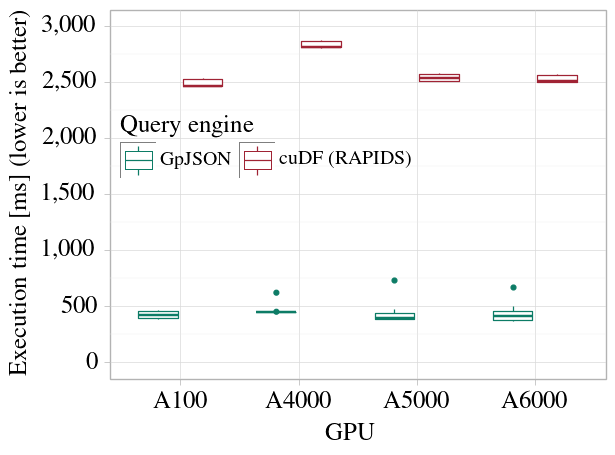

<ggplot: (401497325)>

In [10]:
plt = (
    ggplot(results_df.loc[results_df["size"] == "2x"].reset_index(drop=True))
    + geom_boxplot(aes(x="gpu", y="duration", color="tool"))
    + scale_y_continuous(breaks=[0,500,1000,1500,2000,2500, 3000],
                        labels=["0", "500", "1,000", "1,500", "2,000", "2,500", "3,000"],
                        limits=[0,3000])
    + scale_color_manual(["#0D7C66", "#A02334"])
    + theme_light(base_size=18)
    + ylab("Execution time [ms] (lower is better)") + xlab("GPU")
    + guides(color=guide_legend(title="Query engine"))
    + theme(legend_position=[0.37, 0.6], legend_background=element_rect(fill=(0,0,0,0)),
           axis_text=element_text(size=18, color="black"))
)

plt.save("plots/gpu_vs_rapids.pdf")
plt

In [11]:
gpjson_mem = pd.read_csv("memoryutil/a6000/gpjson_2x.csv").rename(columns={
    " memory.used [MiB]": "mem_used"
})
gpjson_mem["mem_used"] = gpjson_mem["mem_used"].str.split().str[0].astype(int)
gpjson_mem["ts"] = pd.to_datetime(gpjson_mem["timestamp"]).astype(int) // 1e6
gpjson_mem["ts"] = gpjson_mem["ts"] - gpjson_mem["ts"].min()
gpjson_mem = gpjson_mem.loc[gpjson_mem["mem_used"] > 100].reset_index(drop=True)
gpjson_mem

,timestamp,name,utilization.gpu [%],utilization.memory [%],memory.total [MiB],memory.free [MiB],mem_used,ts
0,2024/10/01 15:16:56.463,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,6415.0
1,2024/10/01 15:16:56.651,NVIDIA RTX A6000,1 %,0 %,49140 MiB,48405 MiB,268,6603.0
2,2024/10/01 15:16:56.751,NVIDIA RTX A6000,1 %,0 %,49140 MiB,48405 MiB,268,6703.0
3,2024/10/01 15:16:56.851,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,6803.0
4,2024/10/01 15:16:56.951,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,6903.0
...,...,...,...,...,...,...,...,...
90,2024/10/01 15:17:05.566,NVIDIA RTX A6000,47 %,6 %,49140 MiB,46107 MiB,2566,15518.0
91,2024/10/01 15:17:05.666,NVIDIA RTX A6000,66 %,11 %,49140 MiB,48331 MiB,342,15617.0
92,2024/10/01 15:17:05.766,NVIDIA RTX A6000,40 %,4 %,49140 MiB,48331 MiB,342,15718.0
93,2024/10/01 15:17:05.866,NVIDIA RTX A6000,40 %,4 %,49140 MiB,48331 MiB,342,15817.0


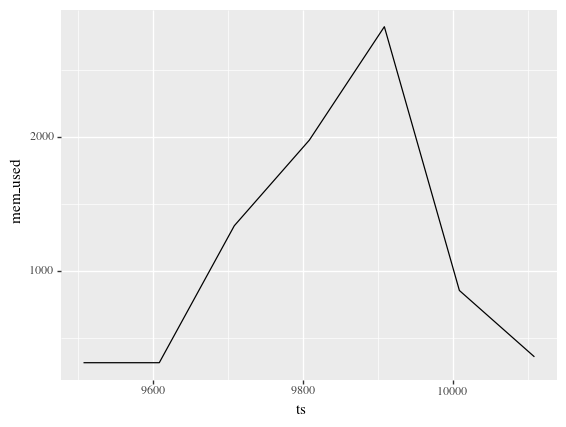

<ggplot: (402273093)>

In [14]:
gpjson_mem_toplot = gpjson_mem.loc[(gpjson_mem["ts"] > 9500) & (gpjson_mem["ts"] < 10200), ["ts", "mem_used"]].reset_index(drop=True)
ggplot(gpjson_mem_toplot) +\
    geom_line(aes(x="ts", y="mem_used"))

In [15]:
cudf_mem = pd.read_csv("memoryutil/a6000/cudf_2x.csv").rename(columns={
    " memory.used [MiB]": "mem_used"
})
cudf_mem["mem_used"] = cudf_mem["mem_used"].str.split().str[0].astype(int)
cudf_mem["ts"] = pd.to_datetime(cudf_mem["timestamp"]).astype(int) // 1e6
cudf_mem["ts"] = cudf_mem["ts"] - cudf_mem["ts"].min()
cudf_mem = cudf_mem.loc[cudf_mem["mem_used"] > 100].reset_index(drop=True)
cudf_mem

,timestamp,name,utilization.gpu [%],utilization.memory [%],memory.total [MiB],memory.free [MiB],mem_used,ts
0,2024/10/01 15:20:55.252,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,4513.0
1,2024/10/01 15:20:55.448,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,4709.0
2,2024/10/01 15:20:55.548,NVIDIA RTX A6000,1 %,0 %,49140 MiB,48405 MiB,268,4809.0
3,2024/10/01 15:20:55.648,NVIDIA RTX A6000,1 %,0 %,49140 MiB,48405 MiB,268,4909.0
4,2024/10/01 15:20:55.749,NVIDIA RTX A6000,0 %,0 %,49140 MiB,48405 MiB,268,5009.0
...,...,...,...,...,...,...,...,...
405,2024/10/01 15:21:35.955,NVIDIA RTX A6000,29 %,4 %,49140 MiB,46591 MiB,2082,45216.0
406,2024/10/01 15:21:36.055,NVIDIA RTX A6000,61 %,5 %,49140 MiB,47877 MiB,796,45316.0
407,2024/10/01 15:21:36.155,NVIDIA RTX A6000,61 %,5 %,49140 MiB,48395 MiB,278,45416.0
408,2024/10/01 15:21:36.255,NVIDIA RTX A6000,16 %,1 %,49140 MiB,48395 MiB,278,45516.0


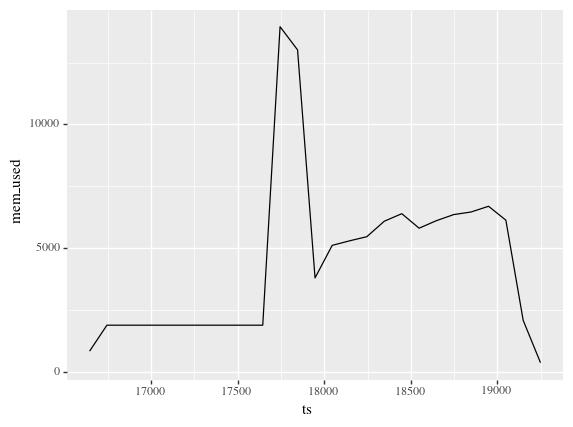

<ggplot: (402286029)>

In [16]:
cudf_mem_toplot = cudf_mem.loc[(cudf_mem["ts"] > 16600) & (cudf_mem["ts"] < 19300), ["ts", "mem_used"]].reset_index(drop=True)
ggplot(cudf_mem_toplot) +\
    geom_line(aes(x="ts", y="mem_used"))

In [17]:
gpjson_mem_toplot["ts"] = gpjson_mem_toplot["ts"] - gpjson_mem_toplot["ts"].min()
gpjson_mem_toplot["tool"] = "GpJSON"
cudf_mem_toplot["ts"] = cudf_mem_toplot["ts"] - cudf_mem_toplot["ts"].min()
cudf_mem_toplot["tool"] = "cuDF (RAPIDS)"
mem_toplot = pd.concat([gpjson_mem_toplot, cudf_mem_toplot]).reset_index(drop=True)

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.11/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/cudf_memory_usage.pdf


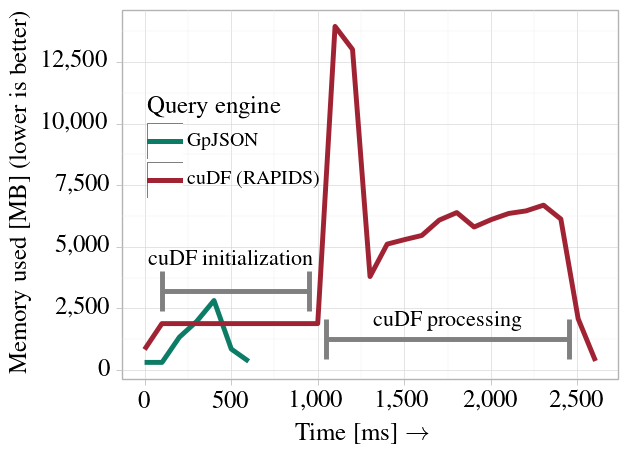

<ggplot: (402401349)>

In [18]:
plt = (
    ggplot(mem_toplot)
    + geom_line(aes(x="ts", y="mem_used", color="tool"), size=2)
    + scale_x_continuous(breaks=[0,500,1000,1500,2000,2500],
                        labels=["0", "500", "1,000", "1,500", "2,000", "2,500"])
    + scale_y_continuous(breaks=[0, 2500, 5000, 7500, 10000, 12500],
                         labels=["0","2,500","5,000","7,500","10,000","12,500"])
    + scale_color_manual(["#0D7C66", "#A02334"])
    + annotate("segment", x=100, xend=950, y=3200, yend=3200, size=2, 
               arrow=arrow(ends="both", angle=90), color="grey")
    + annotate("text", x=500, y=4500, label="cuDF initialization", size=16)
    + annotate("segment", x=1050, xend=2450, y=1250, yend=1250, size=2, 
               arrow=arrow(ends="both", angle=90), color="grey")
    + annotate("text", x=1750, y=2000, label="cuDF processing", size=16)
    + theme_light(base_size=18)
    + ylab("Memory used [MB] (lower is better)") + xlab("Time [ms] $\\rightarrow$")
    + guides(color=guide_legend(title="Query engine", nrow=2))
    + theme(legend_position=[0.3, 0.6], legend_background=element_rect(fill=(0,0,0,0)),
           axis_text=element_text(size=18, color="black"))
)

plt.save("plots/cudf_memory_usage.pdf")
plt

In [259]:
cudf_mem_toplot["mem_used"].max()

13948